## Off-target frequency simulations with no on-target spots

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile
from pyro.infer import Predictive
import pyro.distributions as dist

from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace

### Load results

In [3]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [6]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("negative"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        model = Cosmos()
        model.load(data_path, True, "cpu")
        model.load_parameters(param_path)
        mask = torch.from_numpy(model.data.labels["z"])
        samples = torch.masked_select(model.z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [7]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda").astype(float)
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr
negative0.01,1.4,7.0,0.0,0.01,0.2,90.0,3000.0,150.0,3.758899
negative0.05,1.4,7.0,0.0,0.05,0.2,90.0,3000.0,150.0,3.758899
negative0.15,1.4,7.0,0.0,0.15,0.2,90.0,3000.0,150.0,3.758899
negative0.5,1.4,7.0,0.0,0.50,0.2,90.0,3000.0,150.0,3.758899
negative1,1.4,7.0,0.0,1.00,0.2,90.0,3000.0,150.0,3.758899


In [8]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="lamda")
fit_df["marginal"]

negative0.01    False
negative0.05    False
negative0.15    False
negative0.5     False
negative1       False
Name: marginal, dtype: object

In [9]:
fit_df["classifier"]

negative0.01    False
negative0.05    False
negative0.15    False
negative0.5     False
negative1       False
Name: classifier, dtype: object

In [10]:
fit_df = fit_df.drop(columns=["marginal", "classifier"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,lamda
negative0.01,NaN,7.003336,7.003336,7.003336,7.301212e-16,7.301212e-16,7.301212e-16,0.011953,0.011953,0.011953,...,0.0,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.01
negative0.05,3.487109,7.003784,7.003784,7.003784,3.948652e-39,3.948652e-39,3.948652e-39,0.050861,0.050861,0.050861,...,0.0,0.0,2417.0,83.0,0.0,0.0,0.0,0.0,0.0,0.05
negative0.15,3.525785,7.013232,7.013232,7.013232,3.669837e-39,3.669837e-39,3.669837e-39,0.138727,0.138727,0.138727,...,0.0,0.0,2278.0,222.0,0.0,0.0,0.0,0.0,0.0,0.15
negative0.5,3.538359,7.022739,7.022739,7.022739,2.665805e-39,2.665805e-39,2.665805e-39,0.487442,0.487442,0.487442,...,0.0,0.0,1765.0,735.0,0.0,0.0,0.0,0.0,0.0,0.50
negative1,3.558943,7.070970,7.070970,7.070970,1.478275e-39,1.478275e-39,1.478275e-39,0.969176,0.969176,0.969176,...,0.0,0.0,1183.0,1317.0,0.0,0.0,0.0,0.0,0.0,1.00


### Figure 4

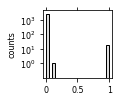

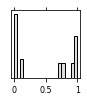

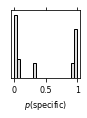

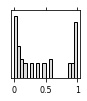

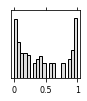

In [15]:
for name in fit_df.index:
    fig, ax = plt.subplots(figsize=(1.25, 1.25))
    ax.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.set_yscale("log")
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(1e-1, 5e3)
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="x", labelsize=8, top=True)
    
    if name == "negative0.01":
        ax.set_ylabel("counts", fontsize=8)
        ax.set_yticks([1, 10, 100, 1000])
        ax.tick_params(axis="y", labelsize=8)
    else:
        ax.set_yticks([])
        ax.tick_params(axis="y", labelsize=8)
    if name == "negative0.15":
        ax.set_xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/logdensity-{name}.svg")
    plt.show()